In [1]:
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
# from sklearn.preprocessing import MinMaxScaler
import pytorch_lightning as pl
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

In [2]:
SYMBOLS = {
    i: idx
    for idx, i in enumerate(
        [
            "BTCUSDT",
            "ETHUSDT",
            "SOLUSDT",
            "BNBUSDT",
            "XRPUSDT",
            "WIFUSDT",
            "DOGEUSDT",
            "PEPEUSDT",
            "SPELLUSDT",
            "SUIUSDT",
            "ADAUSDT",
            "RVNUSDT",
            "JUVUSDT",
            "OMUSDT",
            "LTCUSDT",
            "CREAMUSDT",
            "ACMUSDT",
            "CITYUSDT",
            "TSTUSDT",
            "ATMUSDT",
            "USUALUSDT",
            "DATAUSDT",
            "PORTOUSDT",
            "BARUSDT",
            "TRXUSDT",
            "XLMUSDT",
            "LINKUSDT",
            "JUPUSDT",
            "BNXUSDT",
            "PNUTUSDT",
            "CAKEUSDT",
            "SHIBUSDT",
            "WBTCUSDT",
            "AVAXUSDT",
            "HBARUSDT",
            "TONUSDT",
            "DOTUSDT",
        ]
    )
}

In [3]:
data_root = Path("dataset/bn_spider/csv/")
data_path = data_root / "BNBUSDT_60.csv"
seq_path = data_root / "seq_60.csv"
# data_df = pd.read_csv(data_path)
# seq_df = pd.read_csv(seq_path)

In [4]:
# seq = seq_df[seq_df["stock_name"]=="BNBUSDT"]
# seq

In [5]:
# 读取和预处理 CSV 数据
def load_and_preprocess_data(file_path, interval):
    # 读取 CSV 文件
    data = pd.read_csv(file_path).dropna()

    # 处理缺失值
    data.fillna(value=0, inplace=True)  # 使用前向填充方法处理缺失值

    # # 将 datetime 列转换为时间戳
    # data["timestamp"] = (
    #     pd.to_datetime(data["datetime"]).astype("int64") // 10**9
    # )  # 转换为秒级时间戳

    # # 排序 timestamp
    # data = data.sort_values(by="timestamp", ascending=True)

    # # make index
    # # interval = 14400
    # data["timestamp_diff"] = data["timestamp"].diff().fillna(0).astype("int64")

    # use csv in bn_spider
    interval *= 1000
    data = data.sort_values(by="open_time", ascending=True)
    data["timestamp_diff"] = data["open_time"].diff().fillna(0).astype("int64")

    # seq = pd.DataFrame(columns=["start", "end", "length"])
    # start = 0
    # seq_list = []
    # idx = 0
    # row = None
    # for idx, row in tqdm(data.iterrows(), total=len(data)):
    #     if row.timestamp_diff != interval:
    #         if idx == 0:
    #             continue
    #         seq_list.append([start, idx, idx - start])
    #         start = idx
    # if idx > 0:
    #     idx += 1
    #     seq_list.append([start, idx, idx - start])
    # seq = pd.DataFrame(seq_list, columns=["start", "end", "length"])

    # 使用 shift 和 cumsum 来划分序列
    data["is_new_seq"] = (data["timestamp_diff"] != interval).astype(int)
    data["seq_id"] = data["is_new_seq"].cumsum()

    # 计算每个序列的 start, end, length
    seq = (
        data.groupby("seq_id")
        .agg(
            start=("open_time", "idxmin"),
            end=("open_time", "idxmax"),
            length=("open_time", "size"),
        )
        .reset_index(drop=True)
    )
    seq["end"] += 1

    # gen_seq = generate_fixed_length_sequences(seq, 5)

    # # 提取特征
    # features = data[["open", "high", "low", "close", "volume"]].values

    # # 归一化处理
    # scaler = MinMaxScaler()
    # features_scaled = scaler.fit_transform(features)

    # return data[["open", "high", "low", "close", "volume"]].values, seq

    return (
        data[
            [
                # "stock_name",
                # # "open_time",
                # "interval",
                # "open_price",
                # "high_price",
                "low_price",
                "close_price",
                "volume",
                # "close_time",
                # "quote_asset_volume",
                # "number_of_trades",
                # "taker_buy_base_asset_volume",
                # "taker_buy_quote_asset_volume",
            ]
        ].values,
        seq,
    )


In [6]:
def generate_fixed_length_sequences(df, fixed_length):
    """
    将每个连续区间分割为固定长度的子序列，返回无交叉的区间列表

    参数:
    df (DataFrame): 包含列['start', 'end', 'length']的连续性统计表
    fixed_length (int): 需要生成的固定子序列长度

    返回:
    List[Tuple]: 生成的子序列区间列表，格式为 [(start1, end1), (start2, end2), ...]
    """
    result = []

    for _, row in df.iterrows():
        s = row["start"]
        e = row["end"]
        length = row["length"]
        

        # 跳过长度不足的区间
        if length < fixed_length:
            continue

        # 完全匹配的情况
        if length == fixed_length:
            result.append((s, e))
            continue

        # form offset
        if length // fixed_length == 1:
            offset = np.random.randint(0, length % fixed_length + 1)
        else:
            offset = np.random.randint(0, fixed_length)

        # 生成每个子序列的起始和结束位置
        s += offset
        e = s + fixed_length
        while e <= length+row["start"]:
            result.append((s, e))
            s = e
            e += fixed_length

    return result


In [7]:
# 创建自定义数据集类
class SeqDataset(Dataset):
    def __init__(self, data, seq, sequence_length, predict_length):
        self.data = data
        self.seq = seq
        self.seqList_x = None
        self.seqList_y = None
        # symbol_mapper = np.vectorize(lambda s: SYMBOLS[s])
        # self.data[:, 0] = symbol_mapper(self.data[:, 0])
        self.data = self.data.astype(np.float64)
        self.scaler = None
        # self.scaler = MinMaxScaler(feature_range=(0, 1))
        # self.data = self.scaler.fit_transform(self.data)
        self.sequence_length = sequence_length
        self.predict_length = predict_length

        self.scaler = StandardScaler()
        # self.scaler.fit(self.seqList_x)
        self.scaler.fit(self.data)
        self.data = self.scaler.transform(self.data)
        self.__shuffle__()

    def __shuffle__(self):
        seqs = generate_fixed_length_sequences(
            self.seq, self.sequence_length + self.predict_length
        )
        self.seqList_x = []
        self.seqList_y = []
    
        for seq in seqs:
            data = self.data[seq[0] : seq[1]]

            x = data[0 : self.sequence_length]
            y = data[self.sequence_length :]
            self.seqList_x.append(x)
            self.seqList_y.append(y)
        self.seqList_x = torch.tensor(self.seqList_x, dtype=torch.float32)
        self.seqList_y = torch.tensor(self.seqList_y, dtype=torch.float32)
        # if self.scaler is None:
        #     self.scaler = StandardScaler()
        #     # self.scaler.fit(self.seqList_x)
        #     self.scaler.fit(self.data)
        # self.seqList_x = self.scaler.transform(self.seqList_x)
        # self.seqList_y = self.scaler.transform(self.seqList_y)
        
    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

    def reshuflle(self):
        self.__shuffle__()

    def __len__(self):
        return len(self.seqList_x)

    def __getitem__(self, idx):
        x = self.seqList_x[idx]
        y = self.seqList_y[idx]
        # return torch.tensor(x, dtype=torch.float32), torch.tensor(
        #     y, dtype=torch.float32
        # )
        return x, y

In [8]:
seq_steps=60*24*7
predict_steps=60*24
data, seq = load_and_preprocess_data(data_path, 60)
dataset = SeqDataset(data, seq,seq_steps,predict_steps)
len(dataset)

/tmp/ipykernel_677981/2067383844.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/torch/csrc/utils/tensor_new.cpp:278.)
  self.seqList_x = torch.tensor(self.seqList_x, dtype=torch.float32)


307

In [9]:
dataset.__getitem__(0)[0].shape, dataset.__getitem__(0)[1].shape

(torch.Size([10080, 3]), torch.Size([1440, 3]))

In [10]:
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size)

In [11]:
# 2. 定义LSTM模型
class MultiVarLSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, output_size=3, num_layers=2, seq_steps=10080, predict_steps=1440):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        self.seq_steps = seq_steps
        self.predict_steps = predict_steps
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, output_size*predict_steps)  # 输出为predict_steps*3
        )
    
    def forward(self, x):
        # x shape: (batch_size, time_steps, input_size)
        out, (h_n, c_n) = self.lstm(x)
        # 取最后一个时间步的输出
        out = self.fc(out[:, -1, :])
        # 调整形状为 (batch_size, predict_steps, 3)
        return out.view(-1, predict_steps, 3)

In [12]:
# 初始化模型
model = MultiVarLSTM(
    input_size=3,
    hidden_size=64,
    output_size=3,
    num_layers=2
).cuda()


In [13]:
class Sinkhorn(nn.Module):
    def __init__(self, T=2):
        super(Sinkhorn, self).__init__()
        self.T = T
    def sinkhorn_normalized(self,x, n_iters=10):
        for _ in range(n_iters):
            x = x / torch.sum(x, dim=1, keepdim=True)
            x = x / torch.sum(x, dim=0, keepdim=True)
        return x

    def sinkhorn_loss(self,x, y, epsilon=0.1, n_iters=20):
        Wxy = torch.cdist(x, y, p=1)  # 计算成本矩阵
        K = torch.exp(-Wxy / epsilon)  # 计算内核矩阵
        P = self.sinkhorn_normalized(K, n_iters)  # 计算 Sinkhorn 迭代的结果
        return torch.sum(P * Wxy)  # 计算近似 EMD 损失
    def forward(self, y_s, y_t, mode="classification"):
        softmax = nn.Softmax(dim=1)
        p_s = softmax(y_s/self.T)
        p_t = softmax(y_t/self.T)
        emd_loss = 0.001*self.sinkhorn_loss(x=p_s,y=p_t)
        return emd_loss

In [ ]:
# 4. 训练函数
# epochs=100
epochs = 20
device="cuda:0"
# criterion = nn.MSELoss()
criterion = Sinkhorn()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

model.train()
epoch_loop = tqdm(range(epochs))
for epoch in epoch_loop:
    total_loss = 0
    loop = tqdm(dataloader, total=len(dataloader), leave=False)
    for idx, (X_batch, y_batch) in enumerate(loop, 1):
        optimizer.zero_grad()
        outputs = model(X_batch.to(device))
        # loss = 0
        # for i in range(len(y_batch[0][0])):
        #     loss += criterion(outputs[:, i], y_batch[:, i].to(device))
        loss = criterion(outputs, y_batch.to(device))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # 梯度裁剪
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix({"Loss": f"{loss.item():.4f}"})
    avg_loss = total_loss / len(dataloader)
    scheduler.step(avg_loss)
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
    epoch_loop.set_postfix({"Epoch": f"{epoch+1}/{epochs}", "Loss": f"{avg_loss:.4f}"})
    dataset.reshuflle()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [15]:
X_batch.shape

torch.Size([1, 10080, 3])

# 预测与可视化

In [26]:
import matplotlib.pyplot as plt

In [27]:
dataset.reshuflle()
test_idx = np.random.choice(range(len(dataset)), 1, replace=False)
test_data = dataset.__getitem__(test_idx[0:1])

In [28]:
test_data[0].shape, test_data[1].shape

(torch.Size([1, 10080, 3]), torch.Size([1, 1440, 3]))

In [29]:
model.eval()
input = test_data[0].cuda()
label = test_data[1][0]
with torch.no_grad():
    output = model(input)
    

In [30]:
output.shape

torch.Size([1, 1440, 3])

In [47]:
gt = dataset.inverse_transform(label)
gt

array([[ 16.12770158,  16.13749727, 515.00999919],
       [ 16.12100035,  16.12700391, 406.32000014],
       [ 16.11209617,  16.11210201, 318.39999844],
       ...,
       [ 16.10130562,  16.10639995, 700.18999709],
       [ 16.10770344,  16.11000334, 388.47998732],
       [ 16.10849492,  16.10869662, 439.77003254]])

In [46]:
pred = dataset.inverse_transform(output[0].cpu())
pred

array([[ 232.92534166,  232.66177315, 1143.82683546],
       [ 232.90519038,  232.66815991, 1128.88898408],
       [ 232.92234577,  232.68588066, 1130.09597014],
       ...,
       [ 232.93199033,  232.67181939, 1130.47128024],
       [ 232.92992299,  232.66665686, 1117.27143459],
       [ 232.91467169,  232.65671951, 1117.81587411]])

array([[ 16.12770158,  16.13749727, 515.00999919],
       [ 16.12100035,  16.12700391, 406.32000014],
       [ 16.11209617,  16.11210201, 318.39999844],
       ...,
       [ 16.10130562,  16.10639995, 700.18999709],
       [ 16.10770344,  16.11000334, 388.47998732],
       [ 16.10849492,  16.10869662, 439.77003254]])

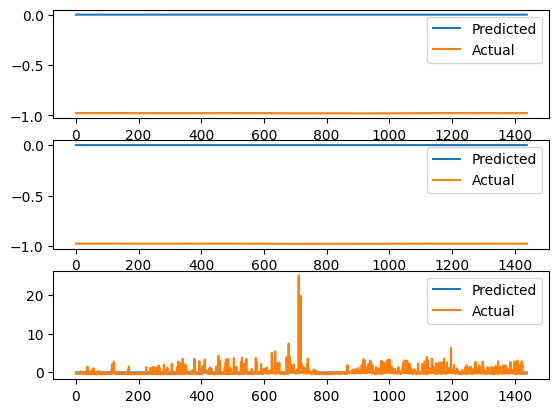

In [ ]:
# plt sub figure (1*3)
fig, axs = plt.subplots(3, 1)
plt.subplots_adjust(wspace=0.3)
for i in range(len(pred[0])):
    axs[i].plot(pred[:, i], label='Pred')
    axs[i].plot(gt[:, i], label='GT')
    axs[i].legend()
plt.show()
